In [9]:
import torch
import os
import sys
from dataclasses import dataclass, field
from typing import Optional
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
import random
from torch.optim import LBFGS, Adam
from pathlib import Path
from tqdm import tqdm
import wandb

# make sure that util is correctly accessed from parent directory
ppp_dir = os.path.abspath(os.path.join(os.getcwd(), "..", ".."))
if ppp_dir not in sys.path:
    sys.path.insert(0, ppp_dir)

from model_parametrized.pinn_ff import PINNff
from ode_dataset import ODEData
from config import HyperparamConfig

In [10]:
cuda_available = torch.cuda.is_available()
print(f"CUDA available: {cuda_available}")

# If CUDA is available, print the CUDA version
if cuda_available:
    print(f"CUDA version: {torch.version.cuda}")
    print(f"Number of CUDA devices: {torch.cuda.device_count()}")
    print(f"Current CUDA device: {torch.cuda.current_device()}")
    print(f"CUDA device name: {torch.cuda.get_device_name(torch.cuda.current_device())}")
    device = 'cuda:0'

seed = 0
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)


CUDA available: True
CUDA version: 11.8
Number of CUDA devices: 1
Current CUDA device: 0
CUDA device name: NVIDIA GeForce GTX 1650 Ti


### Configure initial dataset and hyperparameters

In [11]:
config = HyperparamConfig(
    total_i=500,
    dataset="1d-logistic-ode",
    model_name="pinn_ff",  # Model name
    init_activ_func="sin",
    subseq_activ_func="tanh",
    in_dim=3,
    hidden_dim=256,
    out_dim=1,
    num_layer=4,
    init_weights="xavier uniform",
    bias_fill=0.01,
    optimizer="adam",
    learning_rate=0.001,
    batch_size=128
)

# Validate the configuration
config.validate()

print("Configuration:")
print(config.to_dict())

Configuration:
{'total_i': 500, 'dataset': '1d-logistic-ode', 'model_name': 'pinn_ff', 'in_dim': 3, 'hidden_dim': 256, 'out_dim': 1, 'num_layer': 4, 'init_weights': 'xavier uniform', 'bias_fill': 0.01, 'init_activ_func': 'sin', 'subseq_activ_func': 'tanh', 'optimizer': 'adam', 'learning_rate': 0.001, 'batch_size': 128, 'normalize_res': False, 'normalize_ic': False, 'adaptive_loss_weighting': False}


### 1. Hyperparameter Tuning: Small $\rho$ parameter variance datasets, adam optimizer with mini batching

In [12]:
def compute_relative_errors(model, dataset, rho, device):
    
    # Get test points for the current rho
    x_test, t_test, _ = dataset.get_test_points(rho)
    rho_test = torch.full_like(x_test, rho).to(device)  # Create rho tensor for test points

    # Compute the analytical solution for the test points
    u_analytical = dataset.analytical_solution(x_test, t_test, rho).cpu().detach().numpy().reshape(101, 1)

    # Model predictions
    with torch.no_grad():
        pred = model(x_test.to(device), t_test.to(device), rho_test.to(device))[:, 0:1]
        pred = pred.cpu().detach().numpy().reshape(101, 1)

    # Compute relative errors
    rl1 = np.sum(np.abs(u_analytical - pred)) / np.sum(np.abs(u_analytical))
    rl2 = np.sqrt(np.sum((u_analytical - pred) ** 2) / np.sum(u_analytical ** 2))

    return rl1, rl2

In [13]:
import torch
import wandb
from tqdm import tqdm
from torch.utils.data import DataLoader, TensorDataset

# === Helper Functions ===
def compute_grad_norm(loss, model):
    """Compute and normalize gradient of loss w.r.t. model parameters."""
    grads = torch.autograd.grad(loss, model.parameters(), retain_graph=True, create_graph=True)
    flat_grad = torch.cat([g.view(-1) for g in grads if g is not None])
    return flat_grad / (flat_grad.norm() + 1e-8)

def update_momentum(grads, momentum_dict, alpha):
    """Exponential moving average update for gradient momentum."""
    for key in grads:
        if key not in momentum_dict:
            momentum_dict[key] = grads[key].detach().clone()
        else:
            momentum_dict[key] = alpha * momentum_dict[key] + (1 - alpha) * grads[key].detach()
    return momentum_dict

def compute_loss_weights(momentum_dict):
    """Compute inverse-norm weights from gradient momenta."""
    weights = {k: 1.0 / (v.norm() + 1e-8) for k, v in momentum_dict.items()}
    total = sum(weights.values())
    return {k: weights[k] / total for k in weights}

In [14]:
# === Helper Function for One Training Run ===
def run_training(config_dict, model, optim, dataset, rho_values, device):
    """
    Perform one training run based on the provided configuration.

    Args:
        config_dict (dict): Configuration dictionary containing hyperparameters.
        model (torch.nn.Module): The model to train.
        dataset: Dataset object providing interior and initial condition points.
        rho_values (list): List of rho values for training.
        device (torch.device): Device to run the training on (e.g., 'cuda' or 'cpu').
    """
    wandb.init(
        project="gnn_1d_logistic",
        config=config_dict,
        settings=wandb.Settings(silent=True)
    )

    momentum_dict = {}  # Reset for each run
    loss_track = {}

    for i in tqdm(range(config_dict["total_i"])):
        total_loss_res = 0.0
        total_loss_ic = 0.0
        num_batches = 0

        for rho in rho_values:
            x_res, t_res, rho_res = dataset.get_interior_points(rho)
            interior_dataset = TensorDataset(x_res, t_res, rho_res)
            interior_loader = DataLoader(interior_dataset, batch_size=config_dict["batch_size"], shuffle=True)

            x_ic, t_ic, rho_ic, u_ic = dataset.get_initial_condition(rho)

            for bx, bt, brho in interior_loader:
                bx.requires_grad_()
                bt.requires_grad_()

                pred_res = model(bx.to(device), bt.to(device), brho.to(device))
                u_t = torch.autograd.grad(pred_res, bt.to(device), grad_outputs=torch.ones_like(pred_res),
                                          retain_graph=True, create_graph=True)[0]

                if config_dict["normalize_res"]:
                    normalized_res_error = (u_t - brho * pred_res * (1 - pred_res)) / (
                        config_dict["alpha"] * torch.sqrt(brho) + config_dict["epsilon"])
                    loss_res = torch.mean(normalized_res_error ** 2)
                else:
                    loss_res = torch.mean((u_t - brho * pred_res * (1 - pred_res)) ** 2)

                pred_ic = model(x_ic.to(device), t_ic.to(device), rho_ic.to(device))

                if config_dict["normalize_ic"]:
                    normalized_ic_error = (pred_ic - u_ic.to(device)) / (
                        config_dict["alpha"] * torch.sqrt(brho) + config_dict["epsilon"])
                    loss_ic = torch.mean(normalized_ic_error ** 2)
                else:
                    loss_ic = torch.mean((pred_ic - u_ic.to(device)) ** 2)

                if config_dict["adaptive_loss_weighting"]:
                    grad_res = compute_grad_norm(loss_res, model)
                    grad_ic = compute_grad_norm(loss_ic, model)

                    grads = {'res': grad_res, 'ic': grad_ic}
                    momentum_dict = update_momentum(grads, momentum_dict, config_dict["adaptive_loss_coeff"])
                    gamma = compute_loss_weights(momentum_dict)

                    loss = gamma['res'] * loss_res + gamma['ic'] * loss_ic
                else:
                    loss = loss_res + loss_ic

                optim.zero_grad()
                loss.backward(retain_graph=True)
                optim.step()

                total_loss_res += loss_res.item()
                total_loss_ic += loss_ic.item()
                num_batches += 1

        avg_loss_res = total_loss_res / num_batches
        avg_loss_ic = total_loss_ic / num_batches
        avg_total_loss = avg_loss_res + avg_loss_ic

        wandb_dict = {
            "iteration": i,
            "avg_loss_res": avg_loss_res,
            "avg_loss_ic": avg_loss_ic,
            "avg_total_loss": avg_total_loss
        }

        total_l1 = 0.0
        total_l2 = 0.0
        for rho in rho_values:
            rl1, rl2 = compute_relative_errors(model, dataset, rho, device)
            wandb_dict[f"{rho}_rl1"] = rl1
            wandb_dict[f"{rho}_rl2"] = rl2
            total_l1 += rl1 
            total_l2 += rl2

        average_l1 = total_l1 / len(rho_values) 
        average_l2 = total_l2 / len(rho_values)

        wandb.log(wandb_dict)
        loss_track[i] = wandb_dict

    wandb.finish()
    return loss_track, average_l1, average_l2


In [15]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(config.bias_fill)

In [16]:
# Define rho values
rho_values = [0.5, 0.7, 0.8, 1.0] # small range

# Create the dataset using the ODEData class.
# Note: We now provide t_range, t_points, a constant x value (e.g., 1.0), and rho_values.
dataset = ODEData(t_range=[0, 1], rho_values=rho_values, t_points=101, constant_x=1.0, device='cuda:0')


# === Variations ===
normalize_res_values = [False] #[True, False]
normalize_ic_values = [False] #[True, False]
adaptive_loss = [True, False]
adaptive_loss_weighting_coeffs = [0.5, 0.7, 0.9]
alpha_values = [None]#[0.1, 0.25] #[0.1, 0.25, 0.5]
epsilon_values = [None]#[0.1, 0.3] #[0.1, 0.5, 1.0]
iteration_steps = [50, 100, 400]
models = []
for init_act,subseq_act in [("sin", "tanh"), ("sin","gelu"), ("tanh", "gelu")]:
    model = PINNff(in_dim=config.in_dim, 
                   hidden_dim=config.hidden_dim,
                   out_dim=config.out_dim,
                   num_layer=config.num_layer,
                   init_act_func=init_act,
                   subseq_activ_func=subseq_act).to(device)
    model.apply(init_weights)
    models.append((model,init_act, subseq_act))


# === Grid Search ===
best_model = None
best_config = None
best_l1 = float('inf')
best_l2 = float('inf')

for model,i_act,s_act in models: 
    for normalize_res in normalize_res_values:
        for normalize_ic in normalize_ic_values:
            for a_coeff in adaptive_loss_weighting_coeffs:
                for ad_loss in adaptive_loss:
                    for alpha in alpha_values:
                        for epsilon in epsilon_values:
                            for total_i in iteration_steps:
                                config.normalize_res = normalize_res
                                config.normalize_ic = normalize_ic
                                config.adaptive_loss_coeff = a_coeff
                                config.alpha = alpha
                                config.epsilon = epsilon
                                config.total_i = total_i
                                config.adaptive_loss_weighting = ad_loss
                                config.init_activ_func = i_act 
                                config.subseq_activ_func = s_act
                                config.validate()

                                # Call the training function
                                config_dict = config.to_dict()
                                if config.optimizer == "adam":
                                    optim = Adam(model.parameters(), lr=config_dict["learning_rate"])
                                loss_track, avg_l1, avg_l2 = run_training(config_dict, model, optim, dataset, rho_values, device)

                                # Update the best model if the current one is better
                                if avg_l1 < best_l1 and avg_l2 < best_l2:
                                    best_model = model
                                    best_config = config_dict.copy()
                                    best_l1 = avg_l1
                                    best_l2 = avg_l2

# Print the best model and configuration
print("Best Model Configuration:")
print(best_config)
print(f"Best Average L1 Error: {best_l1}")
print(f"Best Average L2 Error: {best_l2}")

100%|██████████| 50/50 [00:09<00:00,  5.19it/s]


100%|██████████| 100/100 [00:23<00:00,  4.19it/s]


100%|██████████| 400/400 [01:28<00:00,  4.51it/s]


100%|██████████| 50/50 [00:10<00:00,  4.94it/s]


100%|██████████| 100/100 [00:21<00:00,  4.55it/s]


100%|██████████| 400/400 [01:21<00:00,  4.94it/s]


100%|██████████| 50/50 [00:11<00:00,  4.49it/s]


100%|██████████| 100/100 [00:19<00:00,  5.20it/s]


100%|██████████| 400/400 [01:29<00:00,  4.45it/s]


100%|██████████| 50/50 [00:10<00:00,  4.57it/s]


100%|██████████| 100/100 [00:17<00:00,  5.74it/s]


100%|██████████| 400/400 [01:08<00:00,  5.88it/s]


100%|██████████| 50/50 [00:09<00:00,  5.13it/s]


100%|██████████| 100/100 [00:18<00:00,  5.48it/s]


100%|██████████| 400/400 [01:31<00:00,  4.35it/s]


100%|██████████| 50/50 [00:08<00:00,  5.77it/s]


100%|██████████| 100/100 [00:17<00:00,  5.59it/s]


100%|██████████| 400/400 [01:04<00:00,  6.17it/s]


100%|██████████| 50/50 [00:11<00:00,  4.42it/s]


100%|██████████| 100/100 [00:20<00:00,  4.80it/s]


100%|██████████| 400/400 [01:19<00:00,  5.06it/s]


100%|██████████| 50/50 [00:08<00:00,  6.13it/s]


100%|██████████| 100/100 [00:15<00:00,  6.30it/s]


100%|██████████| 400/400 [01:18<00:00,  5.09it/s]


100%|██████████| 50/50 [00:11<00:00,  4.18it/s]


100%|██████████| 100/100 [00:24<00:00,  4.09it/s]


100%|██████████| 400/400 [01:30<00:00,  4.41it/s]


100%|██████████| 50/50 [00:08<00:00,  5.92it/s]


100%|██████████| 100/100 [00:16<00:00,  6.03it/s]


100%|██████████| 400/400 [01:07<00:00,  5.90it/s]


100%|██████████| 50/50 [00:10<00:00,  4.68it/s]


100%|██████████| 100/100 [00:20<00:00,  4.98it/s]


100%|██████████| 400/400 [01:20<00:00,  4.99it/s]


100%|██████████| 50/50 [00:08<00:00,  5.61it/s]


100%|██████████| 100/100 [00:18<00:00,  5.54it/s]


100%|██████████| 400/400 [01:07<00:00,  5.92it/s]


100%|██████████| 50/50 [00:11<00:00,  4.51it/s]


100%|██████████| 100/100 [00:19<00:00,  5.10it/s]


100%|██████████| 400/400 [01:20<00:00,  4.97it/s]


100%|██████████| 50/50 [00:08<00:00,  5.96it/s]


100%|██████████| 100/100 [00:16<00:00,  6.03it/s]


100%|██████████| 400/400 [01:10<00:00,  5.64it/s]


100%|██████████| 50/50 [00:09<00:00,  5.05it/s]


100%|██████████| 100/100 [00:20<00:00,  4.98it/s]


100%|██████████| 400/400 [01:19<00:00,  5.01it/s]


100%|██████████| 50/50 [00:09<00:00,  5.10it/s]


100%|██████████| 100/100 [00:17<00:00,  5.88it/s]


100%|██████████| 400/400 [01:10<00:00,  5.64it/s]


100%|██████████| 50/50 [00:10<00:00,  4.92it/s]


100%|██████████| 100/100 [00:22<00:00,  4.49it/s]


100%|██████████| 400/400 [01:30<00:00,  4.41it/s]


100%|██████████| 50/50 [00:09<00:00,  5.25it/s]


100%|██████████| 100/100 [00:18<00:00,  5.43it/s]


100%|██████████| 400/400 [01:07<00:00,  5.96it/s]


Best Model Configuration:
{'total_i': 400, 'dataset': '1d-logistic-ode', 'model_name': 'pinn_ff', 'in_dim': 3, 'hidden_dim': 256, 'out_dim': 1, 'num_layer': 4, 'init_weights': 'xavier uniform', 'bias_fill': 0.01, 'init_activ_func': 'tanh', 'subseq_activ_func': 'gelu', 'optimizer': 'adam', 'learning_rate': 0.001, 'batch_size': 128, 'normalize_res': False, 'normalize_ic': False, 'adaptive_loss_weighting': True, 'adaptive_loss_coeff': 0.9}
Best Average L1 Error: 0.0011434312909841537
Best Average L2 Error: 0.0013427271042019129


In [40]:
# %%
from pathlib import Path

base_dir = Path(".")  # Base directory for results
images_dir = base_dir / "images"  # Subdirectory for images
weights_dir = base_dir / "weights"  # Subdirectory for stored model

# Create the directories if they don't exist
images_dir.mkdir(parents=True, exist_ok=True)
weights_dir.mkdir(parents=True, exist_ok=True)

In [41]:
import matplotlib.pyplot as plt
import numpy as np

def plot_predictions_and_errors(rho_values, predictions, analytical_solutions, errors, num_cols=4, save_path=None):
    """
    Plot predictions and errors for multiple rho values in a grid layout.

    Args:
        rho_values (list): List of rho values.
        predictions (dict): Dictionary of predictions for each rho value.
        analytical_solutions (dict): Dictionary of analytical solutions for each rho value.
        errors (dict): Dictionary of absolute errors for each rho value.
        num_cols (int): Number of columns in the grid (default: 4).
        save_path (str or Path, optional): Path to save the figure. If None, the figure is not saved.
    """
    num_rho = len(rho_values)
    num_rows = 2  # Fixed: Row 1 for predictions, Row 2 for errors
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(4 * num_cols, 6))

    # Ensure axes is a 2D array even if num_cols == 1
    axes = np.atleast_2d(axes)

    for idx, rho in enumerate(rho_values):
        col = idx % num_cols

        # Extract data for the current rho
        pred = predictions[rho]
        analytical = analytical_solutions[rho]
        abs_error = errors[rho]
        percentage_error = (abs_error / np.maximum(analytical, 1e-8)) * 100  # Avoid division by zero

        ax_pred = axes[0, col]
        ax_pred.plot(pred, label="Prediction", color="blue", linewidth=2)
        ax_pred.plot(analytical, label="Analytical", color="orange", linestyle="dashed", linewidth=2)
        ax_pred.set_title(f"Rho: {rho} - Prediction")
        ax_pred.set_xlabel("t - Time")  # Horizontal axis label
        ax_pred.set_ylabel("u(t) - Value")  # Vertical axis label
        ax_pred.legend()
        

        # Plot absolute and percentage errors (Row 2)
        ax_err = axes[1, col]
        #ax_err.plot(abs_error, label="Absolute Error", color="red", linewidth=2)
        ax_err.plot(percentage_error, label="Percentage Error", color="green", linestyle="dotted", linewidth=2)
        ax_err.set_title(f"Rho: {rho} - Relative Error (%)")
        ax_err.legend()

    # Hide unused subplots if num_rho < num_cols
    for idx in range(num_rho, num_cols):
        axes[0, idx].axis("off")
        axes[1, idx].axis("off")

    # Adjust layout
    plt.tight_layout()

    # Save the figure if a save path is provided
    if save_path:
        plt.savefig(save_path, dpi=300)
        print(f"Figure saved to {save_path}")

    plt.show()

Figure saved to images\predictions_and_errors.png


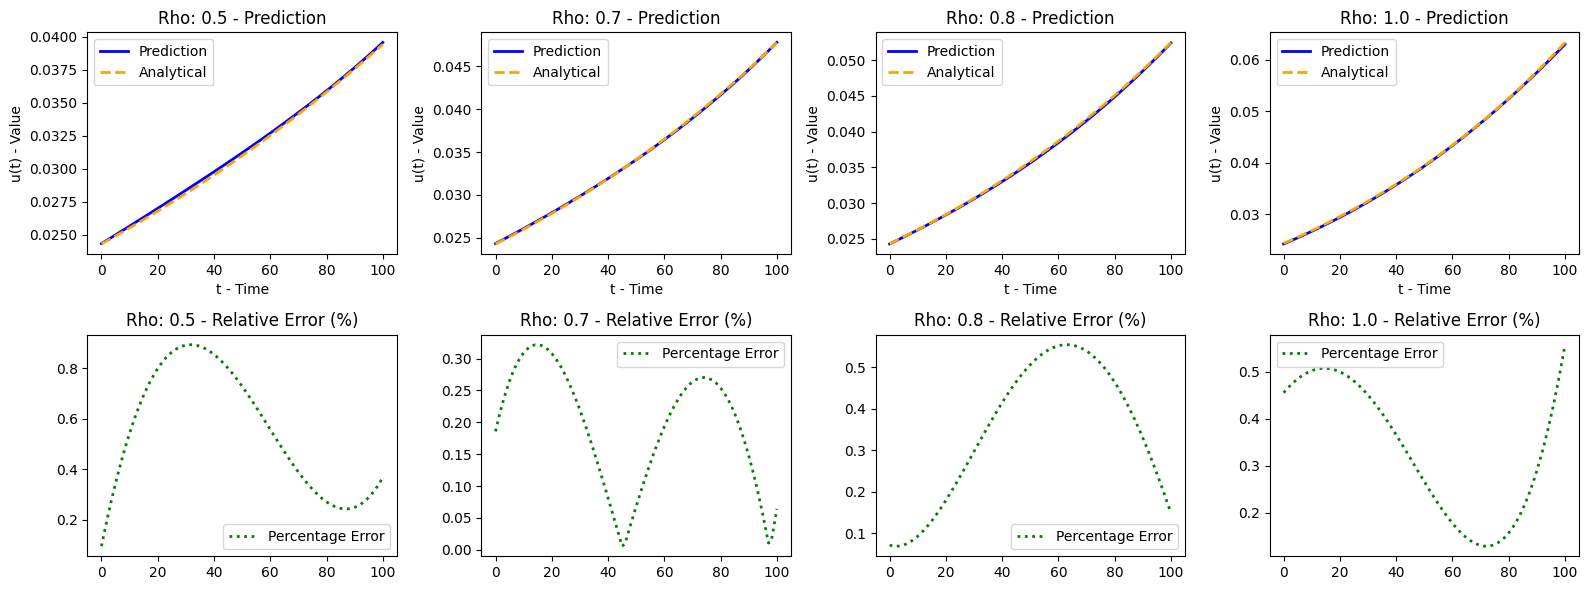

In [42]:
# %%
# Generate predictions and errors for plotting
predictions = {}
analytical_solutions = {}
errors = {}

for rho in rho_values:
    # Get test points for the current rho
    x_test, t_test, _ = dataset.get_test_points(rho)
    rho_test = torch.full_like(x_test, rho).to(device)

    # Compute analytical solution
    u_analytical = dataset.analytical_solution(x_test, t_test, rho).cpu().detach().numpy().reshape(-1)

    # Compute best model predictions
    with torch.no_grad():
        pred = best_model(x_test.to(device), t_test.to(device), rho_test.to(device))[:, 0:1]
        pred = pred.cpu().detach().numpy().reshape(-1)

    # Compute error
    error = np.abs(u_analytical - pred)

    # Store results
    predictions[rho] = pred
    analytical_solutions[rho] = u_analytical
    errors[rho] = error

# Plot predictions and errors
plot_predictions_and_errors(
    rho_values=rho_values,
    predictions=predictions,
    analytical_solutions=analytical_solutions,
    errors=errors,
    num_cols=4,
    save_path=images_dir / "predictions_and_errors.png"
)